In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from time import time
import seaborn as sns
import datetime

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold, TimeSeriesSplit
## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc

In [0]:
# import dill,gzip
# filepath = 'notebook_session.pkl'
# # with gzip.open('./notebook_session', 'wb') as f:
# dill.dump_session(filepath)
# dill.load_session('notebook_session.db')

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
def read_data():    
    df_id = pd.read_csv("/content/ieee-fraud-detection/train_identity.csv")
    df_trans = pd.read_csv("/content/ieee-fraud-detection/train_transaction.csv")
    print("Train Data loaded successfully")
    df_id_test = pd.read_csv("/content/ieee-fraud-detection/test_identity.csv")
    df_trans_test = pd.read_csv("/content/ieee-fraud-detection/test_transaction.csv")
    print("Test Data loaded successfully")
    return df_id,df_trans, df_id_test, df_trans_test

In [8]:
# !pip install kaggle
api_token = {"username":"sudheerraghu","key":"da20c9fa7746bbaf995b9540e671b436"}
import json
import zipfile
import os
filename='/root/.kaggle/kaggle.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
with open(filename, 'w') as file:
    json.dump(api_token, file)
!chmod 600 filename
!kaggle config path -p /content
!kaggle competitions download -c ieee-fraud-detection

if not os.path.exists("/content/ieee-fraud-detection"):
    os.makedirs("/content/ieee-fraud-detection")
os.chdir('/content/ieee-fraud-detection')

for file in os.listdir():
  if zipfile.is_zipfile(file):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

chmod: cannot access 'filename': No such file or directory
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
df_id,df_trans, df_id_test, df_trans_test = read_data()

Train Data loaded successfully
Test Data loaded successfully


In [0]:
def summary_df(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [11]:
### reducing the memory

df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

df_trans_test = reduce_mem_usage(df_trans_test)
df_id_test = reduce_mem_usage(df_id_test)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [12]:
summary_df(df_trans)[:25]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


Text(0.5, 1.0, 'Distribution of LOG TransactionAmt, isFraud=1')

(-1.231, 8.555)

Text(0.5, 1.0, 'Distribution of LOG TransactionAmt, isFraud=0')

(-1.383, 10.375)

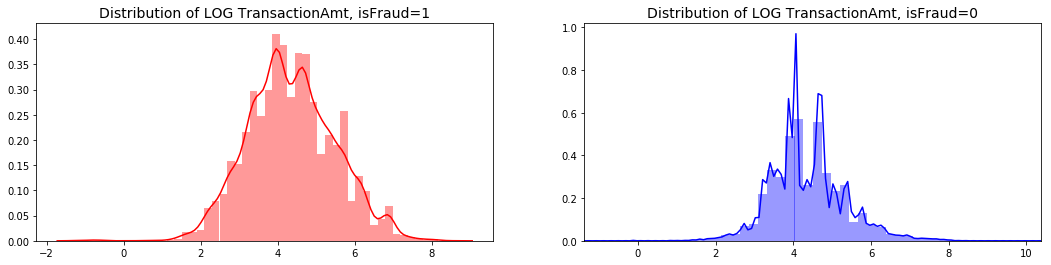

In [13]:
############ LOG transaction amount distribution

fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = df_trans.loc[df_trans['isFraud'] == 1]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[0], color='r')
ax[0].set_title('Distribution of LOG TransactionAmt, isFraud=1', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

time_val = df_trans.loc[df_trans['isFraud'] == 0]['TransactionAmt'].values

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt, isFraud=0', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])


plt.show()

In [14]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum()
total_cnt = df_trans.groupby(['isFraud'])['TransactionID'].count()

print('Total trx amount is :', df_trans.TransactionAmt.sum().astype('float64'))
print('\nFraud by trx amount: {}'.format(total_amt))
print('\nTotal trx count is : {}'.format(df_trans.TransactionAmt.count()))
print('\nBy Trx count:',total_cnt)

Total trx amount is : 79739049.73706055

Fraud by trx amount: isFraud
0    7.665521e+07
1    3.083836e+06
Name: TransactionAmt, dtype: float64

Total trx count is : 590540

By Trx count: isFraud
0    569877
1     20663
Name: TransactionID, dtype: int64


<Figure size 1152x432 with 0 Axes>

Text(0.5, 1.0, 'Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #')

Text(0.5, 0, 'Is fraud?')

Text(0, 0.5, 'Transaction Count')

Text(0.0, 569880, '96.50%')

Text(1.0, 20666, '3.50%')

Text(0.5, 1.0, '% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #')

Text(0.5, 0, 'Is fraud?')

Text(0, 0.5, 'Total Transaction Amount Scalar')

Text(0.0, 76655216.67895508, '96.13%')

Text(1.0, 3083839.0581054688, '3.87%')

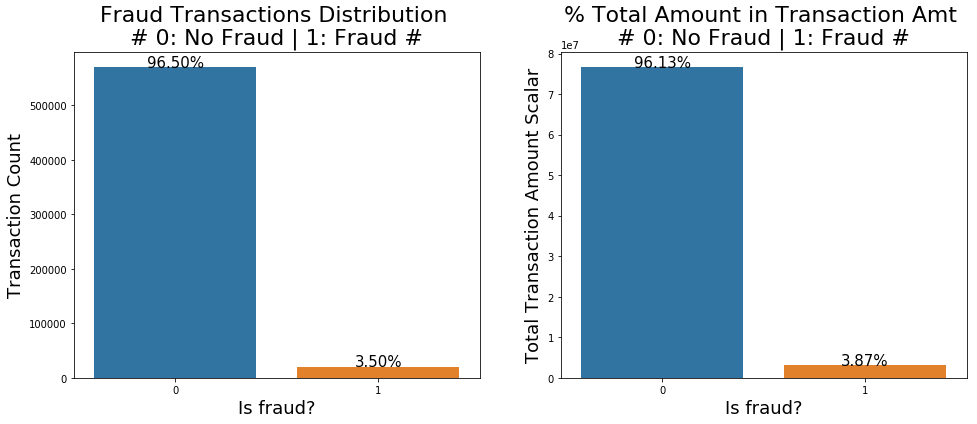

In [15]:
########### Percentage distribution of Fraud and No fraud transactions by transaction count and amount

df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Transaction Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [16]:
######### Quantiles of the Fraud and No fraud transaction amounts

print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


<Figure size 1008x720 with 0 Axes>

Text(0.5, 0.98, 'Product Code Distributions')

Text(0.5, 1.0, 'Product Code Distribution')

Text(0.5, 0, 'ProductCD Name')

Text(0, 0.5, 'Count')

(0, 500000)

Text(0.0, 439673, '74.45%')

Text(1.0, 33027, '5.59%')

Text(2.0, 68522, '11.60%')

Text(3.0, 11631, '1.97%')

Text(4.0, 37702, '6.38%')

Text(0, 0.5, '% of Fraud Transactions')

Text(0.5, 1.0, 'Product CD by Target(isFraud)')

Text(0.5, 0, 'ProductCD Name')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Transaction Amount Distribuition by ProductCD and Target')

Text(0.5, 0, 'ProductCD Name')

Text(0, 0.5, 'Transaction Values')

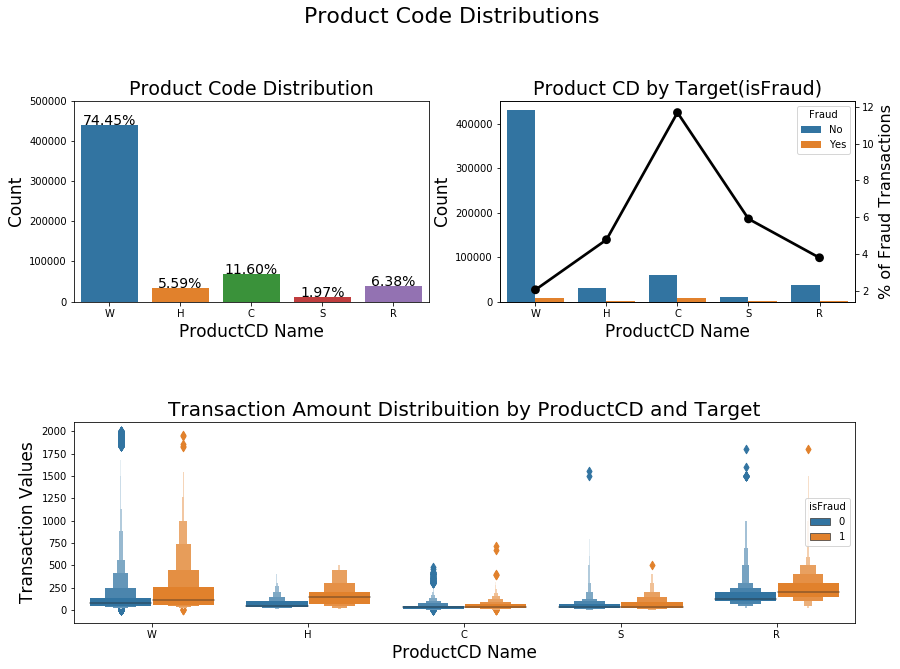

In [17]:
############# Transaction amount distribution by product codes

tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Product Code Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("Product Code Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [18]:
## Knowning the Card Features
summary_df(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [19]:
############ Cards distribution by quantiles

print("Card Features Quantiles are: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([.1, .25, .5, .75, .975, .99]))

Card Features Quantiles are: 
         card1  card2  card3  card5
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


######### Categorical Features 
ProductCD
emaildomain
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9
DeviceType
DeviceInfo
id_12 - id_38

Text(0.5, 1.0, 'ProductCD train')

Text(0.5, 1.0, 'ProductCD test')

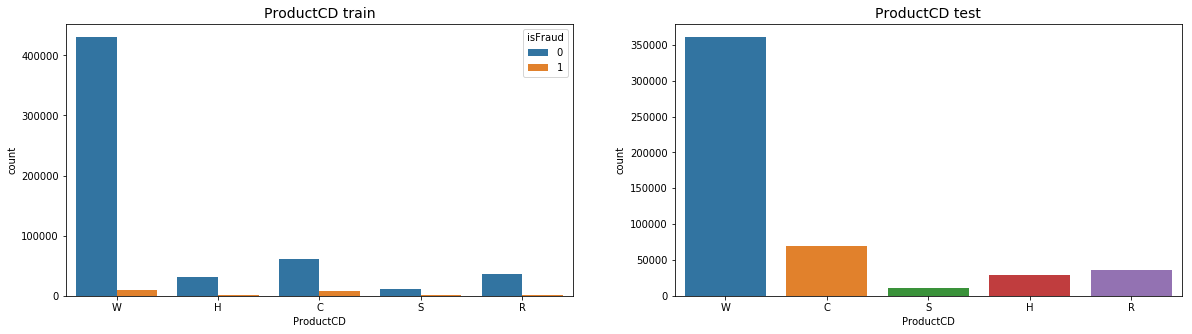

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=df_trans)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=df_trans_test)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

Text(0.5, 1.0, 'card4 isFraud=0')

Text(0.5, 1.0, 'card4 isFraud=1')

Text(0.5, 1.0, 'card6 isFraud=0')

Text(0.5, 1.0, 'card6 isFraud=1')

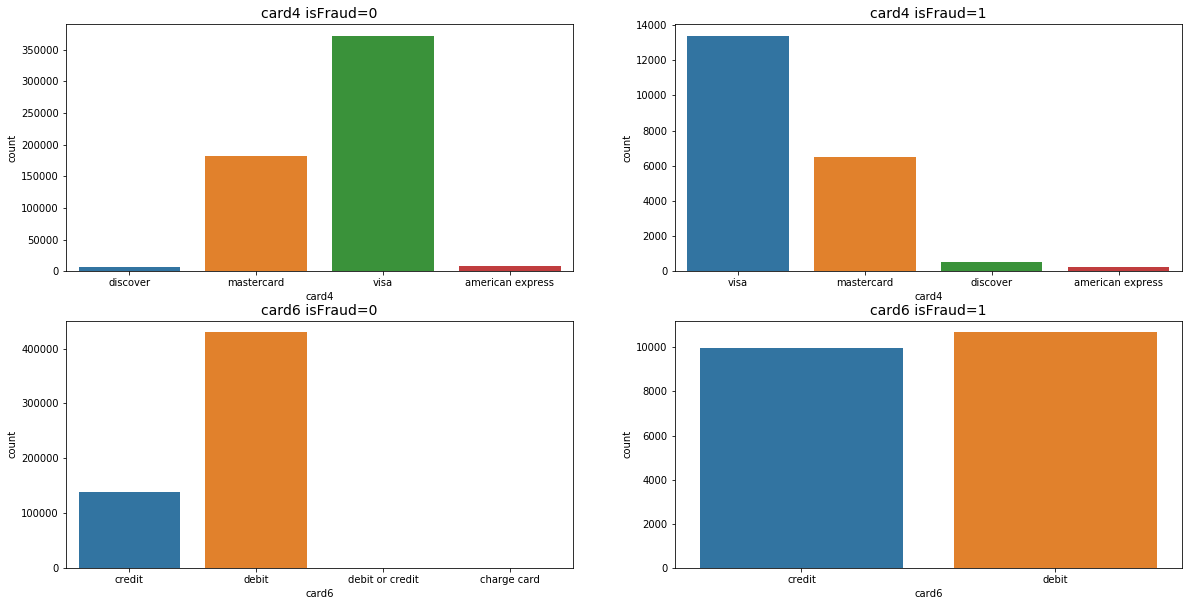

In [21]:
fig, ax = plt.subplots(2, 2,figsize=(20,10))

sns.countplot(x="card4", ax=ax[0,0], data=df_trans.loc[df_trans['isFraud'] == 0])
ax[0,0].set_title('card4 isFraud=0', fontsize=14)
sns.countplot(x="card4", ax=ax[0,1], data=df_trans.loc[df_trans['isFraud'] == 1])
ax[0,1].set_title('card4 isFraud=1', fontsize=14)
sns.countplot(x="card6", ax=ax[1,0], data=df_trans.loc[df_trans['isFraud'] == 0])
ax[1,0].set_title('card6 isFraud=0', fontsize=14)
sns.countplot(x="card6", ax=ax[1,1], data=df_trans.loc[df_trans['isFraud'] == 1])
ax[1,1].set_title('card6 isFraud=1', fontsize=14)
plt.show()

Text(0.5, 1.0, 'DeviceType Train')

Text(0.5, 1.0, 'DeviceType Test')

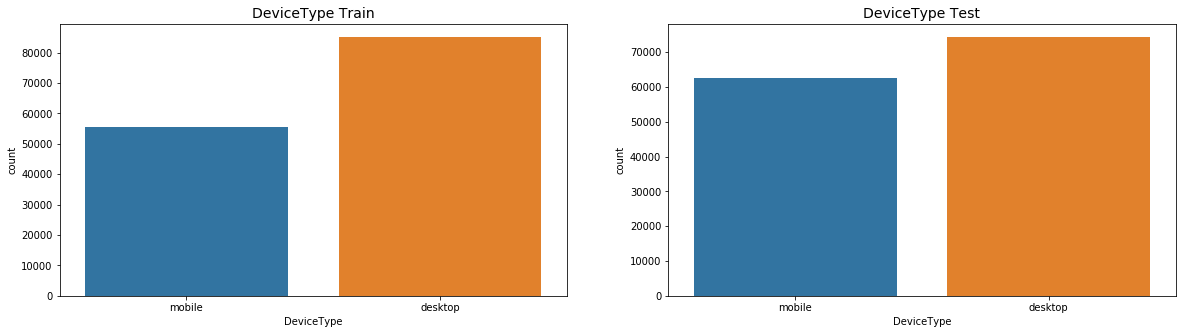

In [22]:
###By Device Type
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0] = sns.countplot(x="DeviceType",ax=ax[0] ,data=df_id)
ax[0].set_title('DeviceType Train', fontsize=14)
ax[1] = sns.countplot(x="DeviceType", ax=ax[1],data=df_id_test)
ax[1].set_title('DeviceType Test', fontsize=14)
plt.show()

# Data Cleaning, Feature engineering and Model Building

In [23]:
import os
os.getcwd()

'/content/ieee-fraud-detection'

In [0]:
# # !pip install kaggle
# api_token = {"username":"sudheerraghu","key":"da20c9fa7746bbaf995b9540e671b436"}
# import json
# import zipfile
# import os
# filename='/root/.kaggle/kaggle.json'
# os.makedirs(os.path.dirname(filename), exist_ok=True)
# with open(filename, 'w') as file:
#     json.dump(api_token, file)
# !chmod 600 filename
# !kaggle config path -p /content
# !kaggle competitions download -c ieee-fraud-detection

# if not os.path.exists("/content/ieee-fraud-detection"):
#     os.makedirs("/content/ieee-fraud-detection")
# os.chdir('/content/ieee-fraud-detection')

# for file in os.listdir():
#     zip_ref = zipfile.ZipFile(file, 'r')
#     zip_ref.extractall()
#     zip_ref.close()

In [25]:
########### Merging the datasets for modelling #########################
df_id,df_trans, df_id_test, df_trans_test = read_data()

train = pd.merge(df_trans, df_id, on='TransactionID', how='left')
test = pd.merge(df_trans_test, df_id_test, on='TransactionID', how='left')

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
y_train = train['isFraud'].astype('uint8')

del df_trans,df_trans_test,df_id,df_id_test
gc.collect()

Train Data loaded successfully
Test Data loaded successfully
Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


9846

In [26]:
########### Grouping R email domains

##### Train Data
train.loc[train['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

train.loc[train['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
train.loc[train['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
train.loc[train.R_emaildomain.isin(train.R_emaildomain\
                                         .value_counts()[train.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
train.R_emaildomain.fillna("NoInf", inplace=True)

train.R_emaildomain.value_counts()

##### Test Data
test.loc[test['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

test.loc[test['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
test.loc[test['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
test.loc[test.R_emaildomain.isin(test.R_emaildomain\
                                         .value_counts()[test.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
test.R_emaildomain.fillna("NoInf", inplace=True)

test.R_emaildomain.value_counts()

NoInf            453249
Google            57242
Microsoft         33604
anonymous.com     20529
Yahoo Mail        13691
aol.com            3701
Others             2275
comcast.net        1812
icloud.com         1398
verizon.net         620
me.com              556
sbcglobal.net       552
cox.net             459
att.net             430
bellsouth.net       422
Name: R_emaildomain, dtype: int64

NoInf            370821
Google            61839
Microsoft         31846
anonymous.com     19115
Yahoo Mail        11221
aol.com            3538
Others             2248
comcast.net        1701
icloud.com         1422
sbcglobal.net       611
verizon.net         582
me.com              539
att.net             440
cox.net             395
bellsouth.net       373
Name: R_emaildomain, dtype: int64

In [27]:
########## Grouping P email domains
##### Train data

train.loc[train['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train.loc[train['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr','ymail.com',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train.loc[train['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train.loc[train.P_emaildomain.isin(train.P_emaildomain\
                                         .value_counts()[train.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train.P_emaildomain.fillna("NoInf", inplace=True)

train.P_emaildomain.value_counts()

############ Test Data

test.loc[test['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

test.loc[test['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr','ymail.com',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
test.loc[test['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
test.loc[test.P_emaildomain.isin(test.P_emaildomain\
                                         .value_counts()[test.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
test.P_emaildomain.fillna("NoInf", inplace=True)

test.P_emaildomain.value_counts()



Google            228851
Yahoo Mail        105305
NoInf              94456
Microsoft          59477
anonymous.com      36998
aol.com            28289
comcast.net         7888
icloud.com          6267
Others              4913
att.net             4033
sbcglobal.net       2970
verizon.net         2705
bellsouth.net       1909
me.com              1522
cox.net             1393
optonline.net       1011
charter.net          816
rocketmail.com       664
mail.com             559
earthlink.net        514
Name: P_emaildomain, dtype: int64

Google           207945
Yahoo Mail        85338
NoInf             69192
Microsoft         53510
anonymous.com     34064
aol.com           24048
comcast.net        6586
icloud.com         6049
Others             5109
att.net            3614
sbcglobal.net      2797
verizon.net        2306
bellsouth.net      1528
cox.net            1264
me.com             1191
optonline.net       926
charter.net         627
mail.com            597
Name: P_emaildomain, dtype: int64

In [28]:
##### Grouping device OS in the column id_30

########## Train Data
train['id_30'] = train.id_30.str.lower()
train.id_30.fillna('',inplace=True)
train['id_30'] = np.where(train['id_30'] == '','other',train['id_30'])
train.loc[train.id_30.str.contains('ios'),'id_30'] = 'ios'
train.loc[train.id_30.str.contains('android'),'id_30'] = 'android'
train.loc[train.id_30.str.contains('windows'),'id_30'] = 'windows'
train.loc[train.id_30.str.contains('mac'),'id_30'] = 'mac'

train.id_30.value_counts()

########## Test Data

test['id_30'] = test.id_30.str.lower()
test.id_30.fillna('',inplace=True)
test['id_30'] = np.where(test['id_30'] == '','other',test['id_30'])
test.loc[test.id_30.str.contains('ios'),'id_30'] = 'ios'
test.loc[test.id_30.str.contains('android'),'id_30'] = 'android'
test.loc[test.id_30.str.contains('windows'),'id_30'] = 'windows'
test.loc[test.id_30.str.contains('mac'),'id_30'] = 'mac'

test.id_30.value_counts()

other      512990
windows     36739
ios         19782
mac         13580
android      6303
linux        1136
func           10
Name: id_30, dtype: int64

other      436036
windows     33038
ios         18720
mac         12054
android      5480
linux        1352
func           11
Name: id_30, dtype: int64

In [0]:
############ Cleaning device info

train['DeviceInfo'] = train.DeviceInfo.str.lower()
train.DeviceInfo.fillna('',inplace=True)
train['DeviceInfo'] = np.where(train['DeviceInfo'] == '','other',train['DeviceInfo'])
train.loc[train.DeviceInfo.str.contains('alcatel'),'DeviceInfo'] = 'alcatel'
train.loc[train.DeviceInfo.str.contains('acquaris'),'DeviceInfo'] = 'acquaris'
train.loc[train.DeviceInfo.str.contains('asus'),'DeviceInfo'] = 'asus'
train.loc[train.DeviceInfo.str.contains('samsung'),'DeviceInfo'] = 'samsung'
train.loc[train.DeviceInfo.str.contains('pixel'),'DeviceInfo'] = 'pixel'
train.loc[train.DeviceInfo.str.contains('moto'),'DeviceInfo'] = 'moto'
train.loc[train.DeviceInfo.str.contains('lenovo'),'DeviceInfo'] = 'lenovo'
train.loc[train.DeviceInfo.str.contains('huawei'),'DeviceInfo'] = 'huawei'
train.loc[train.DeviceInfo.str.contains('nexus'),'DeviceInfo'] = 'nexus'
train.loc[train.DeviceInfo.str.contains('redmi'),'DeviceInfo'] = 'redmi'

train.loc[train.DeviceInfo.str.startswith('lg'),'DeviceInfo'] = 'lg'
train.loc[train.DeviceInfo.str.startswith('sm'),'DeviceInfo'] = 'samsung'
train.loc[train.DeviceInfo.str.startswith('zte'),'DeviceInfo'] = 'zte'
train.loc[train.DeviceInfo.str.startswith('xt'),'DeviceInfo'] = 'xt'

# train.DeviceInfo.value_counts()

########## Test Data

test['DeviceInfo'] = test.DeviceInfo.str.lower()
test.DeviceInfo.fillna('',inplace=True)
test['DeviceInfo'] = np.where(test['DeviceInfo'] == '','other',test['DeviceInfo'])
test.loc[test.DeviceInfo.str.contains('alcatel'),'DeviceInfo'] = 'alcatel'
test.loc[test.DeviceInfo.str.contains('acquaris'),'DeviceInfo'] = 'acquaris'
test.loc[test.DeviceInfo.str.contains('asus'),'DeviceInfo'] = 'asus'
test.loc[test.DeviceInfo.str.contains('samsung'),'DeviceInfo'] = 'samsung'
test.loc[test.DeviceInfo.str.contains('pixel'),'DeviceInfo'] = 'pixel'
test.loc[test.DeviceInfo.str.contains('moto'),'DeviceInfo'] = 'moto'
test.loc[test.DeviceInfo.str.contains('lenovo'),'DeviceInfo'] = 'lenovo'
test.loc[test.DeviceInfo.str.contains('huawei'),'DeviceInfo'] = 'huawei'
test.loc[test.DeviceInfo.str.contains('nexus'),'DeviceInfo'] = 'nexus'
test.loc[test.DeviceInfo.str.contains('redmi'),'DeviceInfo'] = 'redmi'

test.loc[test.DeviceInfo.str.startswith('lg'),'DeviceInfo'] = 'lg'
test.loc[test.DeviceInfo.str.startswith('sm'),'DeviceInfo'] = 'samsung'
test.loc[test.DeviceInfo.str.startswith('zte'),'DeviceInfo'] = 'zte'
test.loc[test.DeviceInfo.str.startswith('xt'),'DeviceInfo'] = 'xt'

# test.DeviceInfo.value_counts()

In [0]:
############ Cleaning id_31

############ Train Data
train['id_31'] = train.id_31.str.lower()
train.id_31.fillna('',inplace=True)
train['id_31'] = np.where(train['id_31'] == '','other',train['id_31'])
train.loc[train.id_31.str.contains('chrome'),'id_31'] = 'chrome'
train.loc[train.id_31.str.contains('firefox'),'id_31'] = 'firefox'
train.loc[train.id_31.str.contains('opera'),'id_31'] = 'opera'
train.loc[train.id_31.str.contains('samsung'),'id_31'] = 'samsung'
train.loc[train.id_31.str.contains('safari'),'id_31'] = 'safari'
train.loc[train.id_31.str.contains('edge'),'id_31'] = 'edge'

# train.DeviceInfo.value_counts()

############ Test Data
test['id_31'] = test.id_31.str.lower()
test.id_31.fillna('',inplace=True)
test['id_31'] = np.where(test['id_31'] == '','other',test['id_31'])
test.loc[test.id_31.str.contains('chrome'),'id_31'] = 'chrome'
test.loc[test.id_31.str.contains('firefox'),'id_31'] = 'firefox'
test.loc[test.id_31.str.contains('opera'),'id_31'] = 'opera'
test.loc[test.id_31.str.contains('samsung'),'id_31'] = 'samsung'
test.loc[test.id_31.str.contains('safari'),'id_31'] = 'safari'
test.loc[test.id_31.str.contains('edge'),'id_31'] = 'edge'

# test.DeviceInfo.value_counts()

In [0]:
########### Cleaning id_33

############ Train Data
train['id_33'] = train.id_33.str.lower()
train.id_33.fillna('0x0',inplace=True)
# train['id_33'] = np.where(train['id_33'] == '','0',train['id_33'])
train['id_33_x'] = train['id_33'].str.split('x',expand = True)[0]
train['id_33_y'] = train['id_33'].str.split('x',expand = True)[1]

train['id_33_y'].replace(np.nan, 0, inplace=True)

train['id_33_x'] = train['id_33_x'].astype(int)
train['id_33_y'] = train['id_33_y'].astype(int)

train.drop('id_33',axis=1,inplace=True)

############ test Data
test['id_33'] = test.id_33.str.lower()
test.id_33.fillna('0x0',inplace=True)
# test['id_33'] = np.where(test['id_33'] == '','0',test['id_33'])
test['id_33_x'] = test['id_33'].str.split('x',expand = True)[0]
test['id_33_y'] = test['id_33'].str.split('x',expand = True)[1]

test['id_33_x'] = test['id_33_x'].astype(int)
test['id_33_y'] = test['id_33_y'].astype(int)

test.drop('id_33',axis=1,inplace=True)

In [32]:
########### Label Encoding the String columns in train and test sets

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

## Train Data
str_columns = train.select_dtypes(include = 'object').columns
str_columns
for f in str_columns:
    train[f] = le.fit_transform(list(train[f]))

### Test Data    
str_columns_test = test.select_dtypes(include = 'object').columns
str_columns_test
for f in str_columns_test:
    test[f] = le.fit_transform(list(test[f]))

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'],
      dtype='object')

In [33]:
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.8]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.8]

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + one_value_cols+ one_value_cols_test))
# cols_to_drop.remove('isFraud')
len(cols_to_drop)

70

In [0]:
############### Dropping the columns with most data missing

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)
y_train = train['isFraud'].astype('uint8')

In [0]:
train['TransactionAmt'] = np.log(train['TransactionAmt'])
test['TransactionAmt'] = np.log(test['TransactionAmt'])

In [0]:
####### Function for PCA
from sklearn.decomposition import PCA

def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    
    pca = PCA(n_components=n_components, random_state=rand_seed)
    
    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [37]:
############# Preprocessing Training data
null_columns = [col for col in train.columns if train[col].isnull().sum() != 0]
null_columns_test = [col for col in test.columns if test[col].isnull().sum() != 0]

###### Calculating columns with missing values and performing PCA

len(null_columns)
train.shape

from sklearn.preprocessing import minmax_scale
train[null_columns] = train[null_columns].replace(np.nan,train[null_columns].mean())
for col in null_columns:
    train[col].fillna(train[col].mean(), inplace=True)
    train[col] = (minmax_scale(train[col], feature_range=(0,1)))

314

(590540, 365)

In [38]:
############# Preprocessing Test data

len(null_columns_test)
from sklearn.preprocessing import minmax_scale
test[null_columns_test] = test[null_columns_test].replace(np.nan,test[null_columns_test].mean())
for col in null_columns_test:
    test[col].fillna(test[col].mean(), inplace=True)
    test[col] = (minmax_scale(test[col], feature_range=(0,1)))
test.shape

286

(506691, 364)

In [39]:
############## Applying PCA on training data
null_cols = list(set(null_columns + null_columns_test))
len(null_cols)

train = PCA_change(train,null_cols,30)


# null_columns = [col for col in train.columns if train[col].isnull().sum() != 0]
len([col for col in train.columns if train[col].isnull().sum() != 0])
train.shape



328

0

(590540, 67)

In [40]:
############## Applying PCA on test data

test = PCA_change(test,null_cols,30)

len([col for col in test.columns if test[col].isnull().sum() != 0])
test.shape

0

(506691, 66)

In [0]:
############ Recursive Features Elimination (RFE) ##################

# from sklearn.svm import SVC
# from sklearn.datasets import make_classification

# from yellowbrick.model_selection import RFECV


############ Instantiate RFECV visualizer with a linear SVM classifier
# visualizer = RFECV(SVC(kernel='linear', C=1))
# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# print('SVC RFE')
# visualizer.show()           # Finalize and render the figure


############ Using Random Forest to determine the feature importance
# cv = StratifiedKFold(5)
# visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring='f1_weighted')

# visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
# print('Random Forrest RFE')
# visualizer.show()           # Finalize and render the figure

In [43]:
############ Dividing the train data into train(80%) and validation(20%) sets #########

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train.drop('isFraud',axis=1),y_train,test_size=.2,random_state=1)
print('Train set: ',X_train.shape, y_train.shape, '\nValidation set: ',X_test.shape,y_test.shape)
print('Test set :', test.shape)

# print(X_train.columns)

Train set:  (472432, 66) (472432,) 
Validation set:  (118108, 66) (118108,)
Test set : (506691, 66)


In [0]:
############ Adding DOW and hour to the train data ###############

X_train['transaction_day_of_week'] = np.floor((X_train['TransactionDT'] / (3600 * 24) - 1) % 7)
X_train['transaction_hour'] = np.floor(X_train['TransactionDT'] / 3600) % 24

X_test['transaction_day_of_week'] = np.floor((X_test['TransactionDT'] / (3600 * 24) - 1) % 7)
X_test['transaction_hour'] = np.floor(X_test['TransactionDT'] / 3600) % 24

In [0]:
############ Adding DOW and hour to the test data ###############

test['transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

test['transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [0]:
############# Dealing imbalanced dataset by using SMOTE (Optional)

# from imblearn.over_sampling import SMOTE

# smote = SMOTE(ratio='minority')
# X_sm, y_sm = smote.fit_sample(X, y)

# plot_2d_space(X_sm, y_sm,X,y, 'SMOTE over-sampling')

# Building XG Boost Model

In [48]:
############### Modelling XG BOOST ###############

%%time
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        gamma = 0.2,
        alpha = 4,
#         missing = 'NAN',
        tree_method='gpu_hist'
    )
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("\nFOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(test)[:,1] / NFOLDS
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("\nOOF AUC = {}".format(roc_auc_score(y_train, y_oof)))


FOLD:  0  AUC 0.957932888821489

FOLD:  1  AUC 0.960016506991774

FOLD:  2  AUC 0.9615124562313129

FOLD:  3  AUC 0.9590563801058569

FOLD:  4  AUC 0.9580184828334106

MEAN AUC = 0.9593073429967687

OOF AUC = 0.9593021426849321
CPU times: user 19min 31s, sys: 14min, total: 33min 32s
Wall time: 33min 34s


In [49]:
############## Choosing the best iteration and predicting for Test set using XGB Classifier

# sub = pd.read_csv('./sample_submission.csv', index_col='TransactionID')
sub = pd.read_csv('/content/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')
sub['isFraud'] = y_preds
sub.to_csv('/content/ieee-fraud-detection/submission_xgboost.csv')
sub.head()

,isFraud
TransactionID,
3663549,0.189748
3663550,0.009383
3663551,0.045498
3663552,0.188801
3663553,0.040186


In [0]:
############# Pickling the XG Boost model

import pickle,gzip
with gzip.open('/content/ieee-fraud-detection/best_model_XGBoost', 'wb') as f:
    pickle.dump(clf, f)
    
############# Loading model
# with gzip.open('/content/ieee-fraud-detection/best_model_XGBoost', 'rb') as f:
#     clf_loaded = pickle.load(f)
# clf_loaded

# Building LGBM Model

In [0]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
#           'device_type': 'gpu'
         }

In [52]:
# !git clone --recursive https://github.com/microsoft/LightGBM ; cd LightGBM
# !mkdir build ; cd build
# !cmake -DUSE_GPU=1 ..
!cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/

CMake Error: The source directory "/content/ieee-fraud-detection" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.


In [53]:
################# LGBM Modelling ####################

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_train, y_train)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
#     X_train,X_test,y_train,y_test
    trn_data = lgb.Dataset(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[test_idx], label=y_train.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.99997	valid_1's auc: 0.9174
[2000]	training's auc: 1	valid_1's auc: 0.918088
Early stopping, best iteration is:
[1519]	training's auc: 1	valid_1's auc: 0.918076
Fold 1 finished in 0:02:37.218953
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999938	valid_1's auc: 0.940821
[2000]	training's auc: 1	valid_1's auc: 0.942393
Early stopping, best iteration is:
[1808]	training's auc: 1	valid_1's auc: 0.942395
Fold 2 finished in 0:05:17.266144
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.9997	valid_1's auc: 0.946392
[2000]	training's auc: 1	valid_1's auc: 0.94863
Early stopping, best iteration is:
[2030]	training's auc: 1	valid_1's auc: 0.948666
Fold 3 finished in 0:08:03.052428
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	tr

<Figure size 1152x1152 with 0 Axes>

Text(0.5, 1.0, '50 TOP feature importance over 5 folds average')

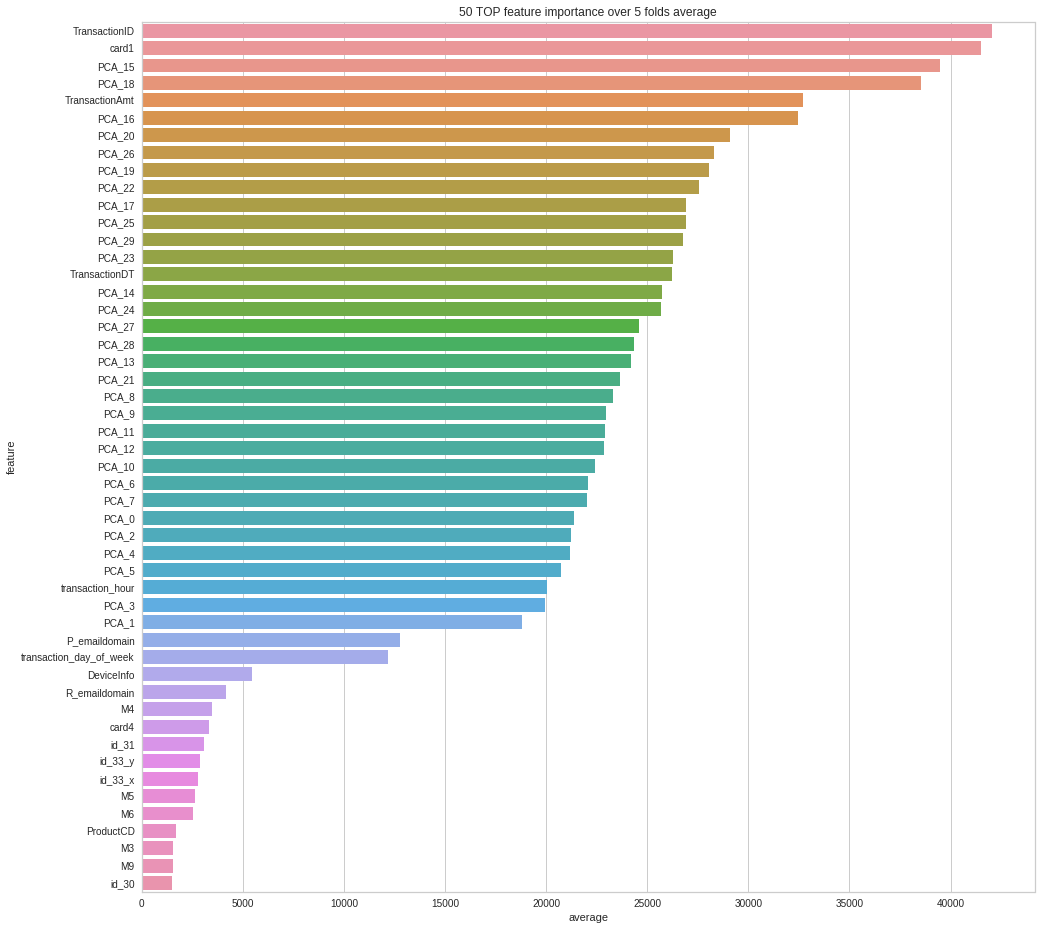

In [54]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits))


In [55]:
############## Choosing the best iteration and predicting for Test set using LGBM
clf
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X_train, y_train)
sub = pd.read_csv('/content/ieee-fraud-detection/sample_submission.csv')
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('/content/ieee-fraud-detection/submission_LGBM.csv', index=False)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=2669, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [0]:
############# Pickling the XG Boost model

import pickle
with gzip.open('/content/ieee-fraud-detection/best_model_LGBM', 'wb') as f:
    pickle.dump(clf, f)
    
# ############# Loading model
# with gzip.open('best_model_LGBM', 'rb') as f:
#     clf_loaded = pickle.load(f)
# clf_loaded

In [57]:
########### Keras data preparation

X_train.shape,X_test.shape,y_train.shape,y_test.shape

(np.array(X_train)).shape
y_train.unique()

def format_to_3d_x(df):
    X = np.array(df)
    return np.reshape(X, (X.shape[0], 1, X.shape[1]))

def format_to_3d_y(df):
    X = np.array(df)
    return to_categorical(X,2)

k_X_train = format_to_3d(X_train)
k_X_test = format_to_3d(X_test)
k_y_train = format_to_3d_y(y_train)
k_y_test = format_to_3d_y(y_test)

((472432, 68), (118108, 68), (472432,), (118108,))

(472432, 68)

array([0, 1], dtype=uint64)

NameError: ignored

In [0]:
################ Implementing Keras model #############

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Flatten,Dense,Dropout
from keras.datasets import mnist
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.utils import to_categorical
from keras.activations import relu,softmax,sigmoid

model = Sequential()
model.add(Flatten())
model.add(Dense(256,activation='sigmoid',input_shape=(80,)))
model.add(Dense(1, activation='softmax'))

model.compile(loss=binary_crossentropy,optimizer=SGD(), metrics=['accuracy'])

model.fit(format_to_3d_x(X_train), np.array(y_train),verbose=0, batch_size=128, epochs=10, validation_data=(format_to_3d_x(X_test),np.array(y_test)))

In [0]:
model.summary()
score = model.evaluate(format_to_3d_x(X_test),np.array(y_test),verbose=0,batch_size=32)
print('Test Loss:',score[0] )
print('Test Accuracy:',score[1] )

In [0]:
model = Sequential()
model.add(Embedding(max_features,128))
model.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(1,activation=sigmoid))

model.compile(loss=binary_crossentropy,optimizer=SGD(),metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test,y_test))
model.evaluate(x_test,y_test,batch_size=32)